# A simple implementation of the MPS Born Machine
[Pan Zhang](http://lib.itp.ac.cn/html/panzhang/)  
Institute of Theoretical Physics, Chinese Academy of Sciences  
Reference: Z. Han, J. Wang, H. Fan, L. Wang and P. Zhang, [Phys. Rev. X 8, 031012 (2018)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031012)

Date: 2019 05 09

In this tutorial I would introduce:
* Constructing matrix product states

* Canonicalization of the MPS using QR

* Single-site update of MPS

* Gradient based single-site learning algorithm

* How to accelarate tensor contractions using GPU.

In [1]:
import sys
import numpy as np
import torch 
import math,time
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1) # Fix seed of the random number generators
np.random.seed(1)

The function below is used to plot mnist images

### Data loading
$1000$ MNIST images have been stored as "mnist784_bin_1000.npy".  
Each image contains $n=28\times 28=784$ pixels, each of which takes value $0$ or $1$.  
Each image is viewed as a product state in the Hilbert space of dimension $2^n$.

In [21]:
n=784 # number of qubits
#m=1000 # m images
m=20
data=np.load("mnist784_bin_1000.npy").astype(np.int32)
data=data[:m,:]
data=torch.LongTensor(data)

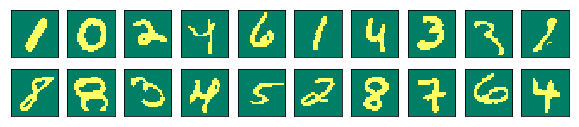

In [22]:
def show_imgs(imgs,l1=4,l2=5,s1=6,s2=6):
    """    Plot images    """
    plt.rcParams['figure.figsize']=(s1,s2)
    imgs=imgs.cpu().reshape([-1,28,28])
    g, ax = plt.subplots(l1,l2)
    for i in range(l1): 
        for j in range(l2):
            a=i*l2+j
            if(a>=imgs.shape[0]):
                break
            ax[i][j].imshow(imgs[a,:,:],cmap='summer')
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    plt.show()
    
show_imgs(data,2,10,10,2)

In [23]:
print("shape of data is ",data.shape )
print(data)

shape of data is  torch.Size([20, 784])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


### MPS initialization
Define the mps, which is a list of 3-way tensors containing random values 
<img src="assets/init.png" width="650px"/>

In [20]:
Dmax=30 # maximum bond dimension
#mydevice=torch.device("cuda:0")
mydevice=torch.device("cpu")
data=data.to(mydevice)
bond_dims=[Dmax for i in range(n-1)]+[1]
tensors= [ torch.randn(bond_dims[i-1],2,bond_dims[i],device=mydevice) for i in range(n)]



In [24]:
print("shape of tensors is",len(tensors))
print([i.shape for i in tensors])

shape of tensors is 784
[torch.Size([1, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), torch.Size([30, 2, 30]), t

Now check the bond dimensions and tensors

In [25]:
print("There are",len(tensors), "tensors")
print(bond_dims)

There are 784 tensors
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3

In [26]:
print("shape of a tensor is",tensors[5].shape)

shape of a tensor is torch.Size([30, 2, 30])


Question: does the contration with one image give a probability of the image?

Answer: No

<img src="assets/px.png" width="1050px"/>
<img src="assets/Z.png" width="1050px"/>

Canonicalization using QR decompositions
* Left canonicalization using sequential QR decompositions. After that, all tensors except the right most ones are isometry with a column orthogonal unforded matrix
<img src="./assets/image-20190430150813001.png" width="300">


<img src="./assets/image-20190430150813001.png" width="300">

In [28]:
def orthogonalize(site,going_right):
    dl=bond_dims[site-1] # left bond dimension
    d=bond_dims[site]   # current bond dimension
    if(going_right):
        A=tensors[site].cpu().view(dl*2,d) # A is a matrix unfolded from the current tensor
        Q,R=torch.qr(A)
        R/=R.norm() # devided by norm 
        tensors[site] = Q.contiguous().view(dl,2,-1).to(mydevice)
        tensors[site+1] = (R.to(mydevice)@tensors[site+1].view(d,-1)).view(-1,2,bond_dims[site+1])
        bond_dims[site] = Q.shape[1] # economy QR, so the right dimension could be either dl or d
    else: # going left
        A=tensors[site].cpu().view(dl,d*2).t()
        Q,R=torch.qr(A)
        R/=R.norm() 
        tensors[site]=Q.t().contiguous().view(-1,2,d).to(mydevice)
        tensors[site-1] = (tensors[site-1].view(-1,dl)@R.t().to(mydevice)).view(bond_dims[site-2],2,-1)
        bond_dims[site-1] = Q.shape[1]


After the canonicalization:
* It make the partition function of the model equals to $1$.  
* The isometries have condition number $1$, preserving very well the computation precisions.

<img src="assets/Z2.png" width="1050px"/>

In [30]:
t0=time.time()
sys.stdout.write("Orthogonalizing...\t")
for site in range(n-1):
    sys.stdout.write("\r site #%d / %d           "%(site+1,n)); sys.stdout.flush()
    orthogonalize(site,True)    
sys.stdout.write("time_used=%.2f Sec.\n"%(time.time()-t0) )   

 site #783 / 784           time_used=0.67 Sec.


In [31]:
print("The shape of the last tensor is",tensors[783].shape)

The shape of the last tensor is torch.Size([30, 2, 1])


Canonicalization changes the bond dimensions from
<img src="assets/init.png" width="650px"/>
to
<img src="assets/init2.png" width="650px"/>

In [33]:
print(bond_dims)

[2, 4, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

Now contracting mps with one image gives the probability amplitude of the image, becuase
<img src="assets/Z2.png" width="1050px"/>
and ?

In [36]:
def get_psi():
    psi=torch.ones([m,1,1],device=mydevice)
    for site in range(n):
        psi = psi @ tensors[site][:,data[:,site],:].permute(1,0,2)
    return(psi)

Generating samples using the *ancestra* sampling
<img src="assets/gen1.png" width="1000px"/>

<img src="assets/gen2.png" width="1000px"/>

<img src="assets/gen3.png" width="1000px"/>

<img src="assets/gen4.png" width="1000px"/>

In [38]:
def gen_samples(ns):
    samples=torch.zeros([ns,n],device=mydevice)
    for site in range(n-1):# left canonicalize
        orthogonalize(site,True) 
    for s in range(ns):
        vec=torch.ones(1,1,device=mydevice)
        for site in range(n-1,-1,-1):
            vec = (tensors[site].view(-1,bond_dims[site])@vec).view(-1,2)
            p0 = vec[:,0].norm()**2/ (vec.norm()**2)
            x = (0 if np.random.rand() < p0 else 1)
            vec = vec[:,x]
            samples[s][site]=x
    return samples

### Initialize cache for MPS
* Computing probability of a image --> contracting from the first tensor to the last tensor. 

* Lots of computation results can be re-used in the future computations.

* We would store the contraction results in the cache.

* Notice that the cache is for all images.

In [39]:
t0=time.time()
cache=[] 
sys.stdout.write("Caching...\t")
sys.stdout.flush()
cache.append( torch.ones([m,1,1],device=mydevice)) # The initial elements, all images have cache 1
for site in range(n-1):
    B=cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)
    B /= B.abs().max()
    cache.append(  B  ) # batched matrix multiplications
cache.append( torch.ones(m,1,1,device=mydevice)) # the last element, matrix [1,1] for all images
sys.stdout.write("time_used=%.2f Sec."%(time.time()-t0) )

Caching...	time_used=0.13 Sec.

* ```B /= B.abs().max()``` is used to preserve computational precision

* Because the gradient is invariant by multiplying the cache by a constant, for each image.  

* Length of the cache is $n+1$. 

* For an image, each pixel has a correponding vector, denoting the temporary results in tensor contractions (from left to right or from right to left).

Let us look at the content of cache for image alpha=1:

In [44]:
alpha=1 # the image 1
print("cache site 1 ",cache[0][alpha])
print("cache site 2 ",cache[1][alpha])
print("cache site 3 ",cache[2][alpha])

cache site 1  tensor([[1.]])
cache site 2  tensor([[-0.0853,  1.0000]])
cache site 3  tensor([[ 1.0000,  0.0972, -0.4895,  0.7524]])


Then the probability amplitude $\psi$ for images is given by $|\psi|^2$ , let us check!

In [42]:
psi=get_psi()
print("Probability of generating image 3 = %.5f"%(psi*psi)[3])

Probability of generating image 3 = 0.00000


**Let us plot probability of all training images**

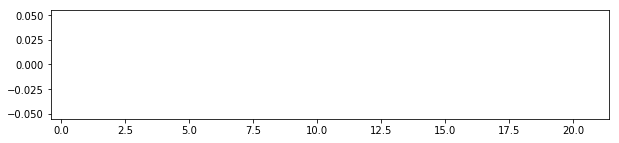

In [43]:
ax=plt.bar(range(1,psi.shape[0]+1),(psi.cpu()**2).squeeze())

**Hey, the probability is $0$, what is wrong?**  

* Because the space is too large and the model is randomly initialized!

* Indeed, the purpose of training is exactly to increase the probability of given images. 

* This is the so-called *maximum likelihood learning*.

* The procedure is sweeping back and force, from right to left, then from left to right. 

* During each sweep, the visited tensor is updated according to the *gradients* of the log-probability with respect to tensor elements.

## Training MPS
<img src="imgs/training.png" width="1000px"/>

** Computing gradient **

$\mathcal{L}=-\frac{1}{m}\sum_{\mathbf{x}\in\mathrm{data}}\ln P(\mathbf{x})$

$\nabla \mathcal{L}=-\frac{2}{m}\sum_{\mathbf{x}\in\mathrm{data}}\frac{\psi'(\mathbf{x})}{\psi(\mathbf{x})}+\frac{Z'}{Z}$
<img src="assets/gradients.png" width="600px"/>

Some tips on the code:
* Only images with $i^{\mathrm{th}}$ element $v_i$ contribute to tensor element $A_{w_{i-1},v_i,w_i}$.
* ```torch.sum(left_vec.permute(0,2,1) @ right_vec.permute(0,2,1)``` computes $\Psi'(\mathbf{x})$.
* ```psi = left_vec @ A.permute(1,0,2) @right_vec ``` does not compute _real_ $\Psi$, as cache is rescaled to preserve precision. Thus one needs to call ```psi=get_psi()``` in order to compute correct probability amplitude $\Psi$.


* ```tensors_bak=tensors.copy()``` is to backup the training environment for restoring after generating images.
* ```@``` operator in ```left_vec @ A.permute(1,0,2) @right_vec ``` and in ```cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)``` works as batched matrix-matrix multiplications.
* In ```orthogonalize()```, imposing matrix $R$ to be norm-one using ```R/=R.norm() ``` actually let the partition function $Z=1$.

**Begin Learning:**

 Epoch #0, site #783 / 784           NLL=72.145, LowerBound=2.996, total_prob=0.000 time_used=3.40 Sec.
 generating samples...

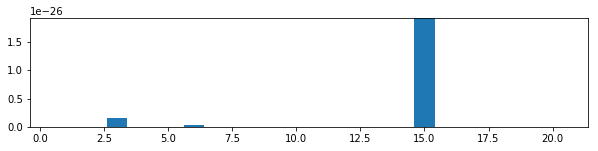

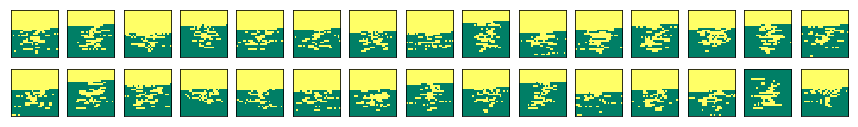

Press any key to continue, or 'stop' to quit stop


In [45]:
learning_rate=0.08
for epoch in range(9):    # one sweep, from right to left, then from left to right
    going_right=False
    t0=time.time()
    for site in [i for i in range(n-1,0,-1)]+[i for i in range(n-1)]:
        # to update tensors[site] which is a 3-way tensor of size [dl,2,dr]
        sys.stdout.write("\r Epoch #%d, site #%d / %d           "%(epoch, site+1,n)); sys.stdout.flush()
        if(site==0): going_right=True
        gradients = torch.zeros_like(tensors[site],device=mydevice)
        for i in [0,1]: # the pixel could be either 0 or 1
            idx=(data[:,site]==i).nonzero().type(torch.LongTensor).squeeze() # this returns indices of non-zero elements
            if(idx.numel()==0): continue
            left_vec = cache[site][idx,:,:] # a vector on the left of the site
            right_vec = cache[site+1][idx,:,:] # a vector on the right of the site
            A=tensors[site][:,data[idx,site],:]
            if(idx.numel()==1): 
                A=A.view(A.shape[0],1,A.shape[1])
                left_vec=left_vec.view(1,left_vec.shape[0],left_vec.shape[1])
                right_vec=right_vec.view(1,right_vec.shape[0],right_vec.shape[1])
            psi = left_vec @ A.permute(1,0,2) @right_vec 
            gradients[:,i,:] = torch.sum(left_vec.permute(0,2,1) @ right_vec.permute(0,2,1) / psi,0) 
        gradients = 2.0*(gradients/m-tensors[site])  
        tensors[site] += learning_rate * gradients/gradients.norm()
        orthogonalize(site,going_right)
        if(going_right): # Update cache
            cache[site+1] = cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)
            cache[site+1] /= cache[site+1].abs().max()
        else:
            cache[site] = tensors[site][:,data[:,site],:].permute(1,0,2) @ cache[site+1]
            cache[site] /= cache[site].abs().max()
    psi=get_psi()
    tensors_bak=tensors.copy()
    sys.stdout.write("NLL=%.3f, LowerBound=%.3f, total_prob=%.3f time_used=%.2f Sec."%(-torch.mean(torch.log(psi*psi)),math.log(m),torch.sum(psi.squeeze()**2),time.time()-t0 ))
    sys.stdout.write("\n generating samples...")
    ax=plt.bar(range(1,psi.shape[0]+1),psi.cpu().squeeze()**2)
    imgs=gen_samples(30)
    show_imgs(imgs,2,15,15,2)
    tensors=tensors_bak.copy()
    if(epoch < 8):
        a=input("Press any key to continue, or 'stop' to quit ")
        if (a=="stop"):
            break


### References for further reading:
* Ulrich Schollwock, “The density-matrix renormalization group in the age of matrix product states,” Annals of Physics 326, 96– 192 (2011).
* Tamara G. Kolda, and Brett W. Bader, "Tensor decompositions and applications", SIAM review 51, 455 (2009).
* Ivan V Oseledets, “Tensor-train decomposition,” SIAM Journal on Scientific Computing 33, 2295–2317 (2011).
* Edwin Miles Miles Stoudenmire and David J. Schwab, “Supervised Learning with Quantum-Inspired Tensor Networks,” Advances in Neural Information Processing Systems 29, 4799 (2016), arXiv:1605.05775.
* Alexander Novikov, Mikhail Trofimov, and Ivan Oseledets, “Exponential machines,” arXiv:1605.05775 (2016).
* Jinguo Liu, and Lei Wang,Differentiable Learning of Quantum Circuit Born Machine, arXiv:1804.04168 (2018).
* Edwin Miles Stoudenmire, “Learning relevant features of data with multi-scale tensor networks,” Quantum Science and Technology (2018).